In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [2]:
# define paths

INPUT_DIR = '/Users/jihoon/venvs/modu_deep/datasets/70dog_breeds_image_dataset'
OUTPUT_DIR = '/Users/jihoon/venvs/modu_deep/model/CNN_InceptionV3'

TRAIN_DIR = '/Users/jihoon/venvs/modu_deep/datasets/70dog_breeds_image_dataset/train'
TEST_DIR = '/Users/jihoon/venvs/modu_deep/datasets/70dog_breeds_image_dataset/test'
VAL_DIR = '/Users/jihoon/venvs/modu_deep/datasets/70dog_breeds_image_dataset/valid'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [3]:
# generate datasets
# ImageDatagenerator to load the images in batches and perform data augmentation

data_gen = ImageDataGenerator(rescale=1/255)

In [5]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=TRAIN_DIR,
                                         shuffle=True,
                                         target_size=DIMS,
                                         class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                        directory=TEST_DIR,
                                        shuffle=True,
                                        target_size=DIMS,
                                        class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                        directory=VAL_DIR,
                                        shuffle=True,
                                        target_size=DIMS,
                                        class_mode='categorical')

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [6]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [6]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet',
                         classes=70)

In [7]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(70, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 70)                143430    
                                                                 
Total params: 21,946,214
Trainable params: 143,430
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3, 
                              verbose=2, 
                              factor=0.001)
es = EarlyStopping(monitor='val_loss',
                   verbose=2, 
                   patience=5, 
                   min_delta=0.001)
checkpoint = ModelCheckpoint(filepath='/Users/jihoon/venvs/modu_deep/model/CNN_InceptionV3/{epoch:02d}-{accuracy:.4f}.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

In [10]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch=train_data.samples//BATCH_SIZE,
                validation_steps=val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr, es, checkpoint])

Epoch 1/10
248/248 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.9617
Epoch 1: val_accuracy improved from -inf to 0.92262, saving model to /Users/jihoon/venvs/modu_deep/model/CNN_InceptionV3/01-0.9617.h5
248/248 [==============================] - 108s 436ms/step - loss: 0.3439 - accuracy: 0.9617 - val_loss: 2.7242 - val_accuracy: 0.9226 - lr: 1.0000e-05
Epoch 2/10
248/248 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.9632
Epoch 2: val_accuracy improved from 0.92262 to 0.92857, saving model to /Users/jihoon/venvs/modu_deep/model/CNN_InceptionV3/02-0.9632.h5
248/248 [==============================] - 109s 440ms/step - loss: 0.3247 - accuracy: 0.9632 - val_loss: 2.6823 - val_accuracy: 0.9286 - lr: 1.0000e-05
Epoch 3/10
248/248 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.9647
Epoch 3: val_accuracy did not improve from 0.92857
248/248 [==============================] - 110s 443ms/step - loss: 0.3048 - accuracy: 

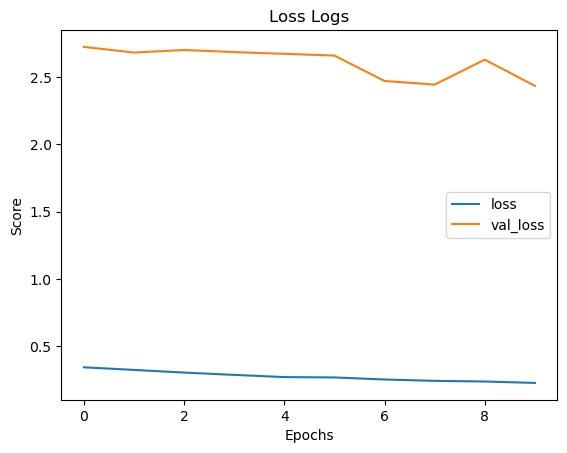

In [12]:
plt.plot(logs.history['loss'], label='loss')
plt.plot(logs.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Loss Logs')
plt.show()

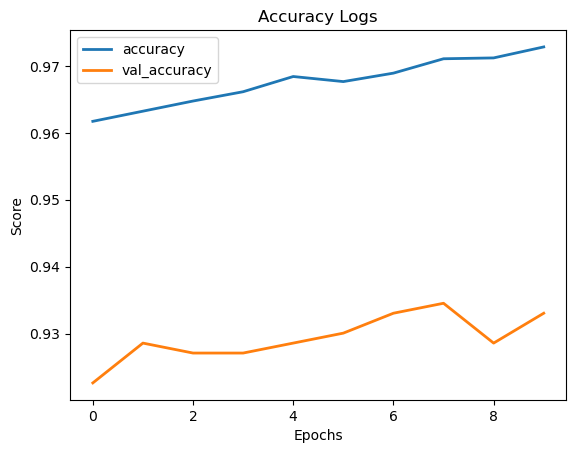

In [13]:
plt.plot(logs.history['accuracy'], label='accuracy', linewidth=2)
plt.plot(logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Logs')
plt.show()

In [7]:
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

In [8]:
from tensorflow import keras
model = keras.models.load_model("/Users/jihoon/venvs/modu_deep/model/CNN_InceptionV3/08-0.9711.h5")

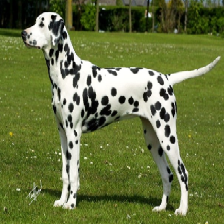

1/1 [==============================] - 0s 51ms/step
(1, 70)


('Dalmation', 1.0)

In [67]:
# requests.get(image_url, stream=True).raw
url = 'https://t1.daumcdn.net/cfile/tistory/993A30335A32B06B25'
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=DIMS)

val,prob = predictor(img)
val,prob

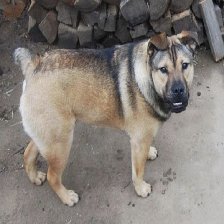

1/1 [==============================] - 0s 33ms/step
(1, 70)


('German Sheperd', 1.0)

In [23]:
# img_path = '/Users/jihoon/Downloads/blackmiko.png'
img_path = '/Users/jihoon/Downloads/test2.png'
img = load_img(img_path, target_size=DIMS)

predictor(img)

In [33]:
# save the model
os.chdir(OUTPUT_DIR)
model.save('Dogs_Breed_Prediction_CNN_InceptionV3.keras')

In [24]:
from tensorflow import keras

def predictor(img_path):
    img = load_img(img_path, target_size=DIMS)
    model = keras.models.load_model("/Users/jihoon/venvs/modu_deep/model/CNN_InceptionV3/08-0.9711.h5")
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

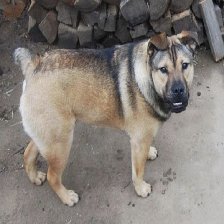

1/1 [==============================] - 0s 394ms/step
(1, 70)


('German Sheperd', 1.0)

In [25]:
predictor("/Users/jihoon/Downloads/test2.png")